In [1]:
from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from IPython.display import Image, display 

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.3-70b-versatile")

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults 

tavily_search = TavilySearchResults(max_results=2)

/tmp/ipykernel_39068/2724907137.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=2)


In [5]:
from langchain_experimental.tools import PythonREPLTool

python_repl_tool = PythonREPLTool()

python_repl_tool.invoke("x=3; print('x ->', x)")

Python REPL can execute arbitrary code. Use with caution.


'x -> 3\n'

Supervisor Agent

In [6]:
class Supervisor(BaseModel):
    next: Literal["enhancer", "researcher", "coder"] = Field(
        description = (
            "Determines which specialist to activate next in the workflow sequence: "
            "'enhancer' when user input requires clarification, expansion, or refinement, "
            "'researcher' when additional facts, context, or data collection is necessary, "
            "'coder' when implementation, computation, or technical problem-solving is required."
        )
    )
    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )


def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:

    system_prompt = ('''
        You are a workflow supervisor managing a team of three specialized agents: Prompt Enhancer, Researcher, and Coder. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.
        2. **Researcher**: Specializes in information gathering, fact-finding, and collecting relevant data needed to address the user's request.
        3. **Coder**: Focuses on technical implementation, calculations, data analysis, algorithm development, and coding solutions.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Continue the process until the user's request is fully and satisfactorily resolved.

        Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
    ''')
    
    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"] 

    response = llm.with_structured_output(Supervisor).invoke(messages)

    goto = response.next
    reason = response.reason

    print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,  
    )

Prompt Enhancer Agent

In [7]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
    
    system_prompt = (
        "You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n"
        "1. Analyzing the original query to identify key intent and requirements\n"
        "2. Resolving any ambiguities without requesting additional user input\n"
        "3. Expanding underdeveloped aspects of the query with reasonable assumptions\n"
        "4. Restructuring the query for clarity and actionability\n"
        "5. Ensuring all technical terminology is properly defined in context\n\n"
        "Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible."
    )

    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"]  

    enhanced_query = llm.invoke(messages)

    print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

    return Command(
        update={
            "messages": [  
                HumanMessage(
                    content=enhanced_query.content, 
                    name="enhancer"  
                )
            ]
        },
        goto="supervisor", 
    )

Researcher Agent

In [8]:
def research_node(state: MessagesState) -> Command[Literal["validator"]]:
    """
        Research agent node that gathers information using Tavily search.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """
    
    research_agent = create_react_agent(
        llm,  
        tools=[tavily_search],
        prompt=(
            "You are an Information Specialist with expertise in comprehensive research. Your responsibilities include:\n\n"
            "1. Identifying key information needs based on the query context\n"
            "2. Gathering relevant, accurate, and up-to-date information from reliable sources\n"
            "3. Organizing findings in a structured, easily digestible format\n"
            "4. Citing sources when possible to establish credibility\n"
            "5. Focusing exclusively on information gathering - avoid analysis or implementation\n\n"
            "Provide thorough, factual responses without speculation where information is unavailable."
        )
    )

    result = research_agent.invoke(state)

    print(f"--- Workflow Transition: Researcher → Validator ---")

    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=result["messages"][-1].content,  
                    name="researcher"  
                )
            ]
        },
        goto="validator",
    )

Coder Agent

In [9]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:

    code_agent = create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=(
            "You are a coder and analyst. Focus on mathematical calculations, analyzing, solving math questions, "
            "and executing code. Handle technical problem-solving and data tasks."
        )
    )

    result = code_agent.invoke(state)

    print(f"--- Workflow Transition: Coder → Validator ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="validator",
    )

Validator Agent

In [10]:
# System prompt providing clear instructions to the validator agent

system_prompt = '''
    Your task is to ensure reasonable quality. 
    Specifically, you must:
    - Review the user's question (the first message in the workflow).
    - Review the answer (the last message in the workflow).
    - If the answer addresses the core intent of the question, even if not perfectly, signal to end the workflow with 'FINISH'.
    - Only route back to the supervisor if the answer is completely off-topic, harmful, or fundamentally misunderstands the question.
    
    - Accept answers that are "good enough" rather than perfect
    - Prioritize workflow completion over perfect responses
    - Give benefit of doubt to borderline answers
    
    Routing Guidelines:
    1. 'supervisor' Agent: ONLY for responses that are completely incorrect or off-topic.
    2. Respond with 'FINISH' in all other cases to end the workflow.
'''


class Validator(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )



def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = llm.with_structured_output(Validator).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto == "FINISH" or goto == END:
        goto = END  
        print(" --- Transitioning to END ---")  
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto, 
    )

In [11]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node) 
graph_builder.add_node("enhancer", enhancer_node)  
graph_builder.add_node("researcher", research_node) 
graph_builder.add_node("coder", code_node) 
graph_builder.add_node("validator", validator_node)  

graph_builder.add_edge(START, "supervisor")

graph = graph_builder.compile()


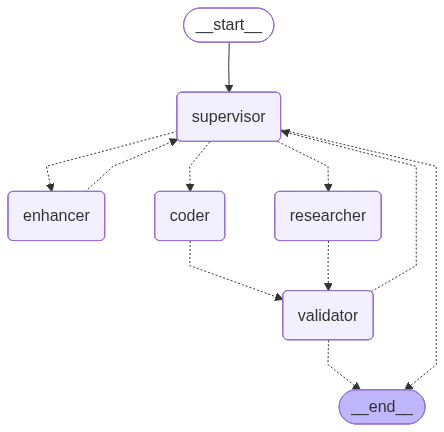

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))

TESTING

In [13]:
from pprint import pprint

inputs = {
    "messages": [
        ("user", "Weather in Egypt?"),
    ]
}

for event in graph.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint(f"Output from node '{key}':")
            pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor → ENHANCER ---
"Output from node 'supervisor':"
HumanMessage(content="The user query 'Weather in Egypt?' is too broad and lacks specificity. The Prompt Enhancer should first refine the query to clarify what aspect of Egypt's weather the user is interested in, such as current weather, forecast, weather by season, or weather in a specific region of Egypt.", additional_kwargs={}, response_metadata={}, name='supervisor', id='041fec5b-6c7f-4eab-9d93-a01ff5ae2049')

--- Workflow Transition: Prompt Enhancer → Supervisor ---
"Output from node 'enhancer':"
HumanMessage(content="To refine the query 'Weather in Egypt?', I will make some informed assumptions to create a more comprehensive and actionable request.\n\nAssuming the user is interested in general information about Egypt's climate, I will expand the query to: 'What are the typical weather conditions in Egypt throughout the year, including temperature, humidity, and precipitation patterns, and how do th

In [15]:
from pprint import pprint

inputs = {
    "messages": [
        ("user", "Give me the 20th fibonacci number"),
    ]
}

for event in graph.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint(f"Output from node '{key}':")
            pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor → CODER ---
"Output from node 'supervisor':"
HumanMessage(content='To find the 20th Fibonacci number, we need to perform a calculation that involves a sequence of numbers where each number is the sum of the two preceding ones, usually starting with 0 and 1. This task requires technical implementation and calculation, which is best handled by the Coder.', additional_kwargs={}, response_metadata={}, name='supervisor', id='eae818d9-8797-44e5-8bc4-3ab1d30b2c5f')

--- Workflow Transition: Coder → Validator ---
"Output from node 'coder':"
HumanMessage(content='The 20th Fibonacci number is 6765.', additional_kwargs={}, response_metadata={}, name='coder', id='6d423dc5-5d9c-4b98-93bf-9361005e8131')

 --- Transitioning to END ---
"Output from node 'validator':"
HumanMessage(content='The answer is correct and addresses the core intent of the question.', additional_kwargs={}, response_metadata={}, name='validator', id='00bb89a9-cbd3-4ca3-bfa6-4640233b625c')

